"""
================================================================================
DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION
Convolutional Neural Networks: Custom Implementation vs Transfer Learning
================================================================================
"""

"""
================================================================================
STUDENT INFORMATION (REQUIRED - DO NOT DELETE)
================================================================================

BITS ID: [Enter your BITS ID here - e.g., 2025AA05036]
Name: [Enter your full name here - e.g., JOHN DOE]
Email: [Enter your email]
Date: [Submission date]

================================================================================
"""

"""
================================================================================
ASSIGNMENT OVERVIEW
================================================================================

This assignment requires you to implement and compare two CNN approaches for
image classification:
1. Custom CNN architecture using Keras/PyTorch
2. Transfer Learning using pre-trained models (ResNet/VGG)

Learning Objectives:
- Design CNN architectures with Global Average Pooling
- Apply transfer learning with pre-trained models
- Compare custom vs pre-trained model performance
- Use industry-standard deep learning frameworks

IMPORTANT: Global Average Pooling (GAP) is MANDATORY for both models.
DO NOT use Flatten + Dense layers in the final architecture.

================================================================================
"""

"""
================================================================================
⚠️ IMPORTANT SUBMISSION REQUIREMENTS - STRICTLY ENFORCED ⚠️
================================================================================

1. FILENAME FORMAT: <BITS_ID>_cnn_assignment.ipynb
   Example: 2025AA05036_cnn_assignment.ipynb
   ❌ Wrong filename = Automatic 0 marks

2. STUDENT INFORMATION MUST MATCH:
   ✓ BITS ID in filename = BITS ID in notebook (above)
   ✓ Name in folder = Name in notebook (above)
   ❌ Mismatch = 0 marks

3. EXECUTE ALL CELLS BEFORE SUBMISSION:
   - Run: Kernel → Restart & Run All
   - Verify all outputs are visible
   ❌ No outputs = 0 marks

4. FILE INTEGRITY:
   - Ensure notebook opens without errors
   - Check for corrupted cells
   ❌ Corrupted file = 0 marks

5. GLOBAL AVERAGE POOLING (GAP) MANDATORY:
   - Both custom CNN and transfer learning must use GAP
   - DO NOT use Flatten + Dense layers
   ❌ Using Flatten+Dense = 0 marks for that model

6. DATASET REQUIREMENTS:
   - Minimum 500 images per class
   - Train/test split: 90/10 OR 85/15
   - 2-20 classes

7. USE KERAS OR PYTORCH:
   - Use standard model.fit() or training loops
   - Do NOT implement convolution from scratch

8. FILE SUBMISSION:
   - Submit ONLY the .ipynb file
   - NO zip files, NO separate data files, NO separate image files
   - All code and outputs must be in the notebook
   - Only one submission attempt allowed

================================================================================
"""

In [1]:
!pip install pandas seaborn torch torchvision pillow opencv-python scikit-learn tensorboard

In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, classification_report
import os, sys, time, json, random, shutil, glob
from pathlib import Path

# Deep learning frameworks (choose Keras or PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

print('PyTorch:', torch.__version__)

# For image processing
from PIL import Image
import cv2

# For metric calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

ROOT = '/content' if Path('/content').exists() else os.getcwd()
LOG_DIR = os.path.join(ROOT, 'logs')
shutil.rmtree(LOG_DIR, ignore_errors=True)

PyTorch: 2.9.0+cu128


"""
================================================================================
PART 1: DATASET LOADING AND EXPLORATION (Informational)
================================================================================

Instructions:
1. Choose ONE dataset from the allowed list
2. Load and explore the data
3. Fill in ALL required metadata fields below
4. Provide justification for your primary metric choice

ALLOWED DATASETS:
- Cats vs Dogs (2 classes)
- Food-101 subset (10-20 classes)
- Plant Disease (3-5 classes)
- Medical Images (2-3 classes)
- Custom dataset (with IC approval, min 500 images per class)

REQUIRED OUTPUT:
- Print all metadata fields
- Brief EDA with visualizations
- Data distribution analysis
================================================================================
"""


## 1.1 Dataset Selection and Loading

### Download dataset

In [3]:
DATA_DIR = os.path.join(ROOT, 'data')
SRC_DIR = os.path.join(DATA_DIR, 'PlantVillage-Dataset')
os.makedirs(DATA_DIR, exist_ok=True)
if Path(os.path.join(SRC_DIR, '.git')).exists():
    print('[Skip] Repo already present at', SRC_DIR)
else:
    print('[Clone] Fetching PlantVillage mirror ...')
    !git clone --depth 1 https://github.com/gabrieldgf4/PlantVillage-Dataset.git "$SRC_DIR"
print('[Sanity] Tomato classes:')
!ls -1 "$SRC_DIR" | grep -E '^Tomato' | sort | sed 's/^/ - /'

SRC_DIR = os.path.join(DATA_DIR, 'PlantVillage-Dataset')
TOMATO_DIR = os.path.join(DATA_DIR, 'tomato_full')
if Path(TOMATO_DIR).exists() and len([d for d in Path(TOMATO_DIR).iterdir() if d.is_dir()]) >= 10:
    print('[Skip] Tomato subset already prepared at', TOMATO_DIR)
else:
    print('[Build] Creating tomato subset at', TOMATO_DIR)
    shutil.rmtree(TOMATO_DIR, ignore_errors=True)
    os.makedirs(TOMATO_DIR, exist_ok=True)
    for d in sorted(Path(SRC_DIR).glob('Tomato___*')):
        if d.is_dir():
            shutil.copytree(str(d), str(Path(TOMATO_DIR)/d.name))
print('[Sanity] Classes in tomato subset:')
for n in sorted(os.listdir(TOMATO_DIR)):
    print(' -', n)

[Clone] Fetching PlantVillage mirror ...
Cloning into '/content/data/PlantVillage-Dataset'...
remote: Enumerating objects: 54326, done.
remote: Counting objects: 100% (54326/54326), done.
remote: Compressing objects: 100% (54326/54326), done.
remote: Total 54326 (delta 0), reused 54285 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54326/54326), 803.82 MiB | 15.93 MiB/s, done.
Updating files: 100% (54306/54306), done.
[Sanity] Tomato classes:
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___healthy
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 - Tomato___Target_Spot
 - Tomato___Tomato_mosaic_virus
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus
[Build] Creating tomato subset at /content/data/tomato_full
[Sanity] Classes in tomato subset:
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mi

### Load dataset

In [4]:
IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
test_split_ratio = 0.15 # 85/15 ratio

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

data_root = os.path.join(DATA_DIR, 'tomato_full')
train_dataset = datasets.ImageFolder(root=data_root, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=data_root, transform=test_transforms)

labels = train_dataset.targets
label_names = train_dataset.classes

# # Dataloader
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [5]:
# REQUIRED: Fill in these metadata fields
dataset_name = "PlantVillage — Tomato subset (10 classes)"
dataset_source = "https://github.com/gabrieldgf4/PlantVillage-Dataset.git"
n_samples = len(labels)  # Total number of images
n_classes = len(np.unique(labels))  # Number of classes
samples_per_class = [{train_dataset.classes[label]: labels.count(label)} for label in np.unique(labels) ]
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

# Primary metric selection
primary_metric = 'accuracy'
metric_justification = ('Accuracy is appropriate because classes are relatively balanced and images are curated; '
                       'for safety-critical deployments we would prefer recall to reduce false negatives.')

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)


DATASET INFORMATION
Dataset: PlantVillage — Tomato subset (10 classes)
Source: https://github.com/gabrieldgf4/PlantVillage-Dataset.git
Total Samples: 18159
Number of Classes: 10
Samples per Class: [{'Tomato___Bacterial_spot': 2127}, {'Tomato___Early_blight': 1000}, {'Tomato___Late_blight': 1909}, {'Tomato___Leaf_Mold': 952}, {'Tomato___Septoria_leaf_spot': 1771}, {'Tomato___Spider_mites Two-spotted_spider_mite': 1676}, {'Tomato___Target_Spot': 1404}, {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357}, {'Tomato___Tomato_mosaic_virus': 373}, {'Tomato___healthy': 1590}]
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is appropriate because classes are relatively balanced and images are curated; for safety-critical deployments we would prefer recall to reduce false negatives.


## 1.2 Data Exploration and Visualization

### Sample images

In [6]:
# Show sample images from each class
print("Sample images from each classes")
class_samples = {}
for idx, label in enumerate(labels):
    if label not in class_samples:
        class_samples[label] = idx
    if len(class_samples) == n_classes:
        break

# Create a grid to display sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, (label_idx, sample_idx) in enumerate(sorted(class_samples.items())):
    # Load image without transforms to show original
    img_path = train_dataset.imgs[sample_idx][0]
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f'{label_names[label_idx]}', fontsize=10, wrap=True)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Plot class distribution

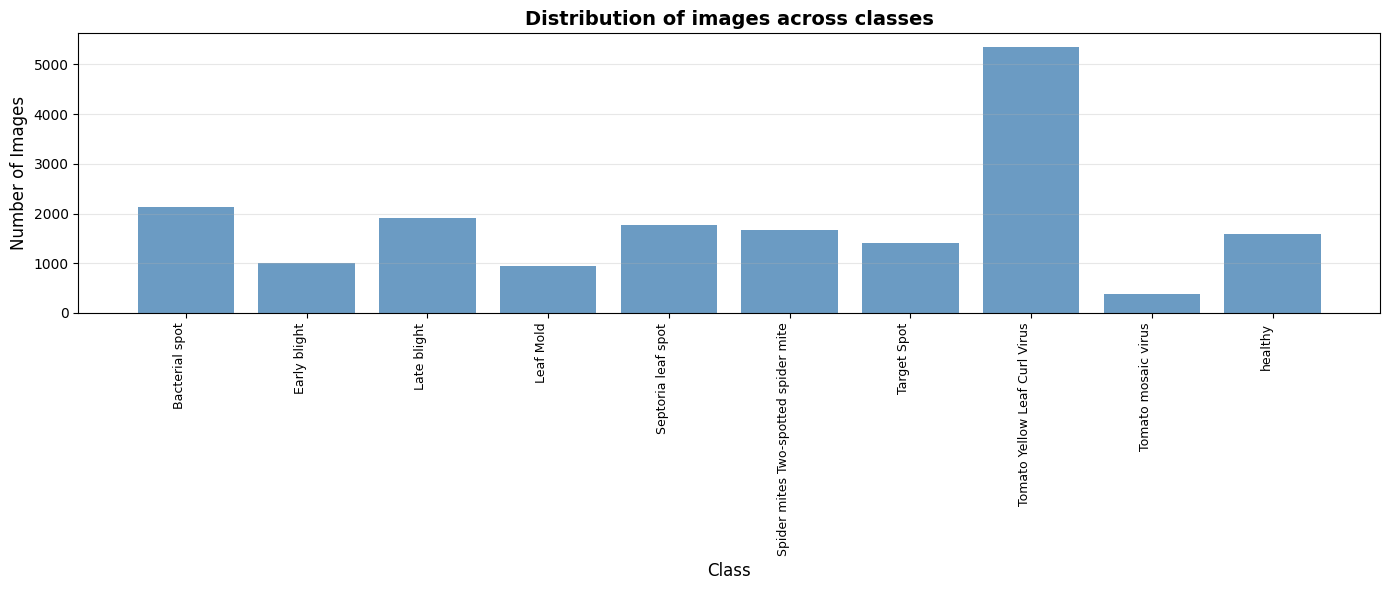

In [7]:
class_counts = [labels.count(i) for i in range(n_classes)]
plt.figure(figsize=(14, 6))
plt.bar(range(n_classes), class_counts, color='steelblue', alpha=0.8)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of images across classes', fontsize=14, fontweight='bold')
plt.xticks(range(n_classes), [name.replace('Tomato___', '').replace('_', ' ') for name in label_names],
           rotation=90, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Display image statistics

In [8]:
sample_img = Image.open(train_dataset.imgs[0][0])
print(f"Sample Image Size: {sample_img.size}")
print(f"Sample Image Mode: {sample_img.mode}")
print(f"Target Image Size (after preprocessing): {IMG_SIZE}x{IMG_SIZE}")
print(f"Normalization Mean: {mean}")
print(f"Normalization Std: {std}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")

Sample Image Size: (256, 256)
Sample Image Mode: RGB
Target Image Size (after preprocessing): 224x224
Normalization Mean: [0.485, 0.456, 0.406]
Normalization Std: [0.229, 0.224, 0.225]
Total Samples: 18159
Number of Classes: 10


## 1.3 Data Preprocessing

In [9]:
# Data Preprocessing and Train/Test Split
# Images are resized to 224x224 and normalized using ImageNet statistics
# Train/Test split: 85/15 with stratification to maintain class balance

SPLIT_CHOICE = "85_15"
train_test_ratio = 0.1 if SPLIT_CHOICE=='90_10' else 0.15

# Train and test transforms takes care of data processing,
# copied down here for to have one more look at it
# train_transforms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])
# test_transforms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std),
# ])

train_index, test_index = train_test_split(
    range(len(labels)),
    test_size=train_test_ratio,
    random_state=42,
    stratify=labels
)

train_data = Subset(train_dataset, train_index)
test_data  = Subset(test_dataset,  test_index)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

train_samples = len(train_data)
test_samples = len(test_data)

print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 0.15
Training Samples: 15435
Test Samples: 2724


"""
================================================================================
PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)
================================================================================

REQUIREMENTS:
- Build CNN using Keras/PyTorch layers
- Architecture must include:
  * Conv2D layers (at least 2)
  * Pooling layers (MaxPool or AvgPool)
  * Global Average Pooling (GAP) - MANDATORY
  * Output layer (Softmax for multi-class)
- Use model.compile() and model.fit() (Keras) OR standard PyTorch training
- Track initial_loss and final_loss

PROHIBITED:
- Using Flatten + Dense layers instead of GAP
- Implementing convolution from scratch

GRADING:
- Architecture design with GAP: 2 marks
- Model properly compiled/configured: 1 mark
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================
"""

### 2.1 Custom CNN Architecture Design

In [10]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """
    class CustomCNN(nn.Module):
        def __init__(self, input_shape, num_classes):
            super(CustomCNN, self).__init__()
            in_channels = input_shape[-1]
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(32,32,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 224->112
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(64,64,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 112->56
            )
            self.conv3 = nn.Sequential(
                nn.Conv2d(64,128,3,padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(128,128,3,padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2) # 56->28
            )
            self.class_conv = nn.Conv2d(128, num_classes, kernel_size=1, bias=True)
            self.gap = nn.AdaptiveAvgPool2d(1)
        def forward(self, x):
            x = self.conv1(x); x = self.conv2(x); x = self.conv3(x)
            x = self.class_conv(x)
            x = self.gap(x)
            x = x.flatten(1) # (N, num_classes) raw logits
            return x

    return CustomCNN(input_shape, n_classes).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Create model instance

In [11]:
model_cnn = build_custom_cnn(image_shape, n_classes)

#### Compile model

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

### 2.2 Train Custom CNN

In [14]:
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

#TensorBoard writers
writer_cnn = SummaryWriter(log_dir=os.path.join(LOG_DIR, 'model_cnn'))

# Track training time
custom_cnn_start_time = time.time()

# Train your model
EPOCHS = 10

initial_loss_value = None
final_loss_value = None

custom_cnn_losses = [] # List to store loss per epoch

start_time = time.time()
for epoch in range(1, EPOCHS+1):
    model_cnn.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_cnn(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds==labels).sum().item()
        running_total += labels.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_correct / max(1, running_total)
    custom_cnn_losses.append(epoch_loss) # Store epoch loss
    if epoch == 1: initial_loss_value = epoch_loss
    final_loss_value = epoch_loss
    writer_cnn.add_scalar('Loss/train', epoch_loss, epoch)
    writer_cnn.add_scalar('Accuracy/train', epoch_acc, epoch)
    custom_cnn_training_time = time.time() - custom_cnn_start_time
    print(f'[ModelCNN] Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | Elapsed time : {custom_cnn_training_time:.2f}s')


custom_cnn_training_time = time.time() - custom_cnn_start_time

# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = initial_loss_value  # TODO: Get from training history (first epoch)
custom_cnn_final_loss = final_loss_value  # TODO: Get from training history (last epoch)

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print("="*70)



CUSTOM CNN TRAINING
[ModelCNN] Epoch 1/10 - Loss: 0.8594 | Acc: 0.7043 | Elapsed time : 104.64871406555176
[ModelCNN] Epoch 2/10 - Loss: 0.6157 | Acc: 0.7902 | Elapsed time : 208.73540210723877
[ModelCNN] Epoch 3/10 - Loss: 0.4666 | Acc: 0.8494 | Elapsed time : 314.89320397377014
[ModelCNN] Epoch 4/10 - Loss: 0.3664 | Acc: 0.8809 | Elapsed time : 420.91956186294556
[ModelCNN] Epoch 5/10 - Loss: 0.3193 | Acc: 0.8991 | Elapsed time : 527.3870804309845
[ModelCNN] Epoch 6/10 - Loss: 0.2495 | Acc: 0.9188 | Elapsed time : 639.1150770187378
[ModelCNN] Epoch 7/10 - Loss: 0.2264 | Acc: 0.9270 | Elapsed time : 756.1571247577667
[ModelCNN] Epoch 8/10 - Loss: 0.2086 | Acc: 0.9322 | Elapsed time : 873.6468696594238
[ModelCNN] Epoch 9/10 - Loss: 0.1690 | Acc: 0.9456 | Elapsed time : 992.7312350273132
[ModelCNN] Epoch 10/10 - Loss: 0.2113 | Acc: 0.9314 | Elapsed time : 1122.5429615974426
Training completed in 1122.54 seconds
Initial Loss: 0.8594
Final Loss: 0.2113


### 2.3 Evaluate Custom CNN

In [17]:
model_cnn.eval()
y_pred, y_test = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model_cnn(imgs)
        p = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(p)
        y_test.extend(labels.numpy())

# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_test, y_pred)
custom_cnn_precision = precision_score(y_test, y_pred, average='macro')
custom_cnn_recall = recall_score(y_test, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_test, y_pred, average='macro')

cnn_results = {
    'initial_loss': float(initial_loss_value),
    'final_loss': float(final_loss_value),
    'training_time': float(custom_cnn_training_time),
    'accuracy': float(custom_cnn_accuracy),
    'precision': float(custom_cnn_precision),
    'recall': float(custom_cnn_recall),
    'f1': float(custom_cnn_f1),
}

print("\nModel CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")



Model CNN Performance:
Accuracy:  0.9391
Precision: 0.9143
Recall:    0.9260
F1-Score:  0.9164


### 2.4 Visualize Custom CNN Results

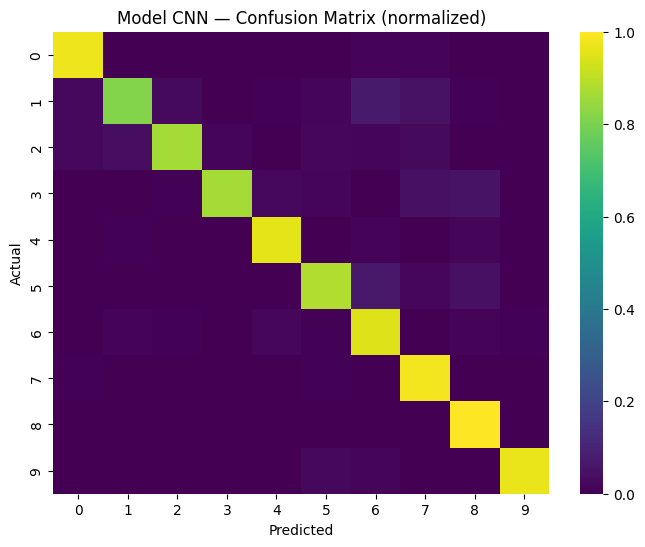

In [18]:

# TODO: Plot training loss curve
# TODO: Plot confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix_result / np.maximum(confusion_matrix_result.sum(axis=1, keepdims=True),1), cmap='viridis', cbar=True)
plt.title('Model CNN — Confusion Matrix (normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# TODO: Show sample predictions


"""
================================================================================
PART 3: TRANSFER LEARNING IMPLEMENTATION (5 MARKS)
================================================================================

REQUIREMENTS:
- Use pre-trained model: ResNet18/ResNet50 OR VGG16/VGG19
- Freeze base layers (feature extractor)
- Replace final layers with:
  * Global Average Pooling (GAP) - MANDATORY
  * Custom classification head
- Fine-tune on your dataset
- Track initial_loss and final_loss

GRADING:
- Valid base model with frozen layers: 2 marks
- GAP + custom head properly implemented: 1 mark
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================
"""

### 3.1 Load Pre-trained Model and Modify Architecture

In [21]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

# load pre-trained model
pretrained_model_name = "ResNet18"
writer_tl  = SummaryWriter(log_dir=os.path.join(LOG_DIR, 'resnet18_tl'))


def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model

    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled transfer learning model
    """
    # Load pre-trained model without top layers
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Freeze base layers
    for p in resnet18.parameters():
      p.requires_grad = False

    class ResNet18_GAP(nn.Module):
      def __init__(self, backbone, num_classes):
          super().__init__()
          self.features = nn.Sequential(
              backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool,
              backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
          )
          self.class_conv = nn.Conv2d(512, num_classes, kernel_size=1, bias=True)
          self.gap = nn.AdaptiveAvgPool2d(1)
          for p in self.features.parameters(): p.requires_grad = False
          for p in self.class_conv.parameters(): p.requires_grad = True
      def forward(self, x):
          x = self.features(x)
          x = self.class_conv(x)
          x = self.gap(x)
          x = x.flatten(1)
          return x

    return ResNet18_GAP(resnet18, num_classes=n_classes).to(device)

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=1e-3)


# REQUIRED: Count layers and parameters
total_parameters, trainable_parameters, frozen_params = count_params(transfer_model)
frozen_layers = sum(1 for p in transfer_model.parameters() if p.requires_grad)  # TODO: Count frozen layers
trainable_layers = sum(1 for p in transfer_model.parameters() if not p.requires_grad)  # TODO: Count trainable layers

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")
print("="*70)


TRANSFER LEARNING IMPLEMENTATION
Base Model: ResNet18
Frozen Layers: 2
Trainable Layers: 60
Total Parameters: 11,181,642
Trainable Parameters: 5,130
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")

# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

# Track training time
tl_start_time = time.time()

# Train model
initial_loss_tl = None
final_loss_tl = None
for epoch in range(1, tl_epochs+1):
    transfer_model.train()
    running, running_correct, running_total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_tl.zero_grad(set_to_none=True)
        logits = transfer_model(imgs)
        loss = criterion_tl(logits, labels)
        loss.backward()
        optimizer_tl.step()
        running += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds==labels).sum().item()
        running_total += labels.size(0)
    epoch_loss = running / len(train_loader.dataset)
    epoch_acc  = running_correct / max(1, running_total)
    if epoch == 1: initial_loss_tl = epoch_loss
    final_loss_tl = epoch_loss
    writer_tl.add_scalar('Loss/train', epoch_loss, epoch)
    writer_tl.add_scalar('Accuracy/train', epoch_acc, epoch)
    print(f'[ResNet18 TL] Epoch {epoch}/{tl_epochs} - Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
train_time_tl = time.time() - tl_start_time
writer_tl.flush()


tl_training_time = time.time() - tl_start_time

# REQUIRED: Track initial and final loss
tl_initial_loss = initial_loss_tl  # TODO: Get from training history (first epoch)
tl_final_loss = final_loss_tl  # TODO: Get from training history (last epoch)

print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print("="*70)

In [ ]:
# 3.3 Evaluate Transfer Learning Model

transfer_model.eval()
y_pred, y_test = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = transfer_model(imgs)
        p = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(p)
        y_test.extend(labels.numpy())

# REQUIRED: Calculate all 4 metrics
tl_accuracy = accuracy_score(y_test, y_pred)
tl_precision = precision_score(y_test, y_pred, average='macro')
tl_recall = recall_score(y_test, y_pred, average='macro')
tl_f1 = f1_score(y_test, y_pred, average='macro')

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

### 3.4 Visualize Transfer Learning Results

In [ ]:
# TODO: Plot training curves (loss and accuracy)

In [22]:
# TODO: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm/np.maximum(cm.sum(axis=1, keepdims=True),1), cmap='viridis', cbar=True)
plt.title('ResNet18 TL — Confusion Matrix (normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# TODO: Show sample predictions

NameError: name 'y_true' is not defined

"""
================================================================================
PART 4: MODEL COMPARISON AND VISUALIZATION (Informational)
================================================================================

Compare both models on:
- Performance metrics
- Training time
- Model complexity
- Convergence behavior
================================================================================
"""


In [ ]:

# 4.1 Metrics Comparison

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)

In [ ]:
# 4.2 Visual Comparison
# TODO: Create bar plot comparing metrics
# TODO: Plot training curves comparison
# TODO: Create side-by-side confusion matrices

"""
================================================================================
PART 5: ANALYSIS (2 MARKS)
================================================================================

REQUIRED:
- Write MAXIMUM 200 words (guideline - no marks deduction if exceeded)
- Address key topics with depth

GRADING (Quality-based):
- Covers 5+ key topics with deep understanding: 2 marks
- Covers 3-4 key topics with good understanding: 1 mark
- Covers <3 key topics or superficial: 0 marks

Key Topics:
1. Performance comparison with specific metrics
2. Pre-training vs training from scratch impact
3. GAP effect on performance/overfitting
4. Computational cost comparison
5. Transfer learning insights
6. Convergence behavior differences
================================================================================
"""

In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

# REQUIRED: Print analysis with word count
print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)

"""
================================================================================
PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)
================================================================================

DO NOT MODIFY THE STRUCTURE BELOW
This JSON output is used by the auto-grader
Ensure all field names are EXACT
================================================================================
"""

In [ ]:


def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "pytorch"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

# Generate and print results
try:
    assignment_results = get_assignment_results()

    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)

except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")



"""
================================================================================
ENVIRONMENT VERIFICATION - SCREENSHOT REQUIRED
================================================================================

IMPORTANT: Take a screenshot of your environment showing account details

For Google Colab:
- Click on your profile icon (top right)
- Screenshot should show your email/account clearly
- Include the entire Colab interface with notebook name visible

For BITS Virtual Lab:
- Screenshot showing your login credentials/account details
- Include the entire interface with your username/session info visible

Paste the screenshot below this cell or in a new markdown cell.
This helps verify the work was done by you in your environment.

================================================================================
"""

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")
print("="*70)


In [ ]:

"""
================================================================================
FINAL CHECKLIST - VERIFY BEFORE SUBMISSION
================================================================================

□ Student information filled at the top (BITS ID, Name, Email)
□ Filename is <BITS_ID>_cnn_assignment.ipynb
□ All cells executed (Kernel → Restart & Run All)
□ All outputs visible
□ Custom CNN implemented with Global Average Pooling (NO Flatten+Dense)
□ Transfer learning implemented with GAP
□ Both models use Keras or PyTorch (NOT from scratch)
□ Both models trained with loss tracking (initial_loss and final_loss)
□ All 4 metrics calculated for both models
□ Primary metric selected and justified
□ Analysis written (quality matters, not just word count)
□ Visualizations created
□ Assignment results JSON printed at the end
□ No execution errors in any cell
□ File opens without corruption
□ Submit ONLY .ipynb file (NO zip, NO data files, NO images)
□ Only one submission attempt

================================================================================
"""
